# Risk Scoring Model

This Notebook shows the construction of the Machine Learning model with the aim of assesing the assoiciated risk of a credit request.

## Python Libraries

In [125]:
# Data managing
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Preprocesing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Optimization
from sklearn.model_selection import GridSearchCV

# ML Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier

# Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Other
from collections import Counter

In [2]:
# Enable seeing plots within the notebook
%matplotlib inline

## Data Read

Read the dataset as a Pandas DataFrame

In [3]:
df = pd.read_csv('../Data/german_credit_data_labels.csv')
df.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.shape

(1000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
ID                  1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(5), object(6)
memory usage: 86.0+ KB


In [6]:
df['Risk'].isnull().any()

False

Label distribution. The dataset is a bit unbalanced

In [7]:
df['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

We encode the label for the data analysis phase

In [8]:
df.loc[df['Risk'] == 'good', 'Risk'] = 0
df.loc[df['Risk'] == 'bad', 'Risk'] = 1
df['Risk'] = df['Risk'].astype(int)

## Data Analysis

General scatter plot

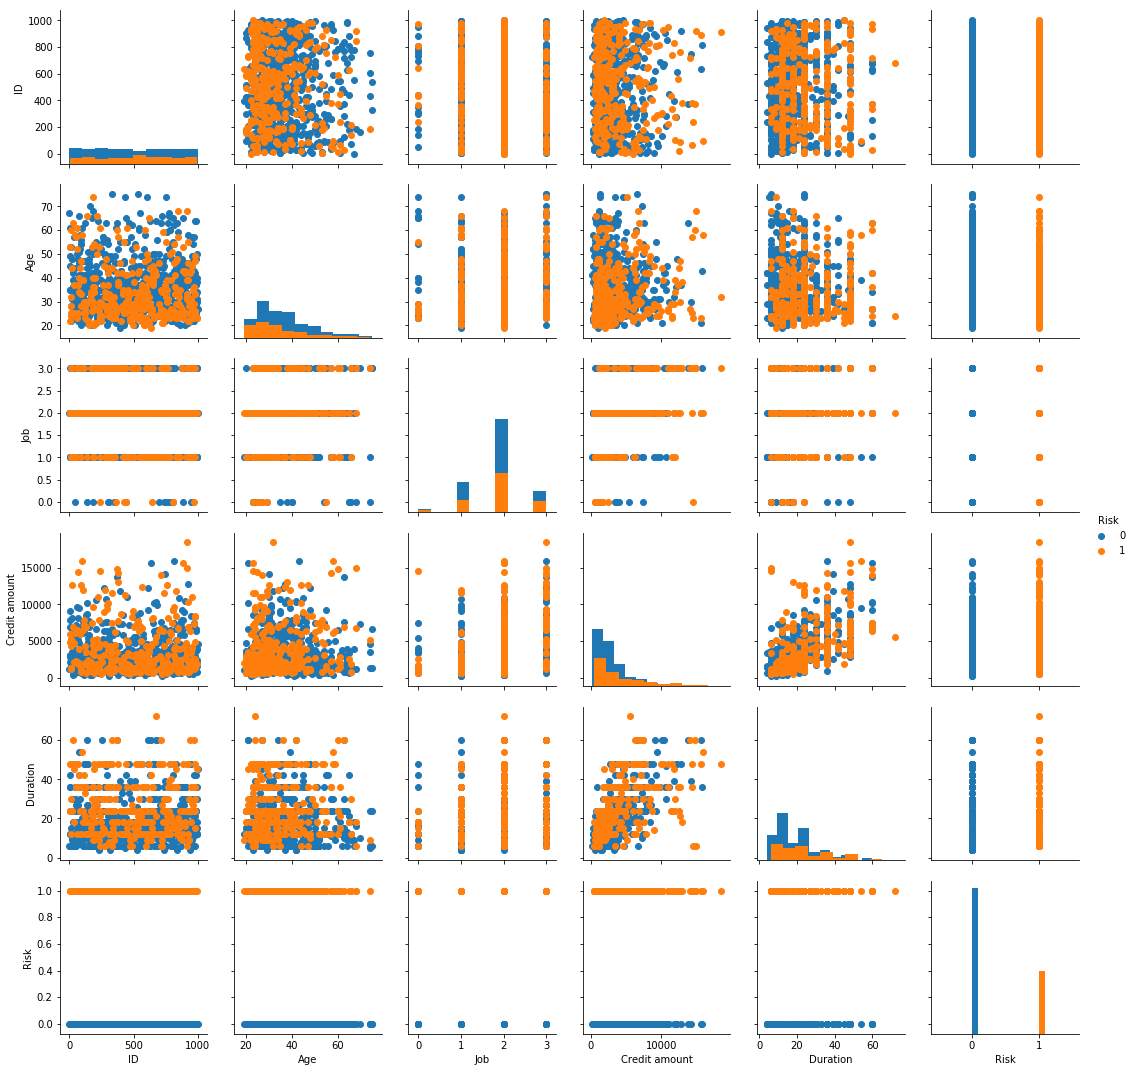

In [10]:
g = sns.PairGrid(df, hue="Risk")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

Possible values for categorical features.

In [11]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
df.groupby('Sex').mean()['Risk']

Sex
female    0.351613
male      0.276812
Name: Risk, dtype: float64

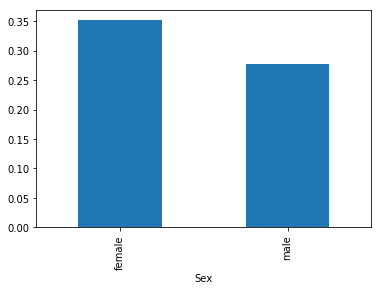

In [13]:
df.groupby('Sex').mean()['Risk'].plot(kind='bar')

In [14]:
total_males = df['Sex'].value_counts()['male']
total_females = df['Sex'].value_counts()['female']

lr = low risk

In [15]:
lr_males = df[df['Risk'] == 0].groupby('Sex').count()['Risk']['male']
lr_females = df[df['Risk'] == 0].groupby('Sex').count()['Risk']['female']

Text(0.5, 1.0, 'Females risk dsitribution')

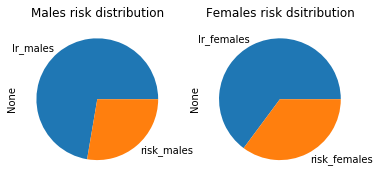

In [16]:
plt.subplot(121)
pd.Series({'lr_males': lr_males, 'risk_males': total_males - lr_males}).plot(kind='pie').set_title('Males risk distribution')
plt.subplot(122)
pd.Series({'lr_females': lr_females, 'risk_females': total_females - lr_females}).plot(kind='pie').set_title('Females risk dsitribution')

There is not differences between sex

In [17]:
df['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [18]:
df.groupby('Housing').mean()['Risk']

Housing
free    0.407407
own     0.260870
rent    0.391061
Name: Risk, dtype: float64

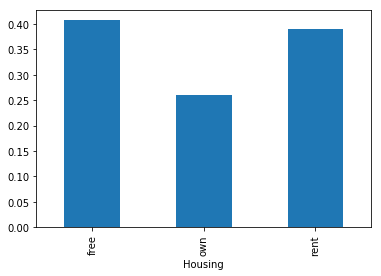

In [19]:
df.groupby('Housing').mean()['Risk'].plot(kind='bar')

In [20]:
lr_free = df[df['Risk'] == 0].groupby('Housing').count()['Risk']['free']
lr_own = df[df['Risk'] == 0].groupby('Housing').count()['Risk']['own']
lr_rent = df[df['Risk'] == 0].groupby('Housing').count()['Risk']['rent']

hr_free = df[df['Risk'] == 1].groupby('Housing').count()['Risk']['free']
hr_own = df[df['Risk'] == 1].groupby('Housing').count()['Risk']['own']
hr_rent = df[df['Risk'] == 1].groupby('Housing').count()['Risk']['rent']

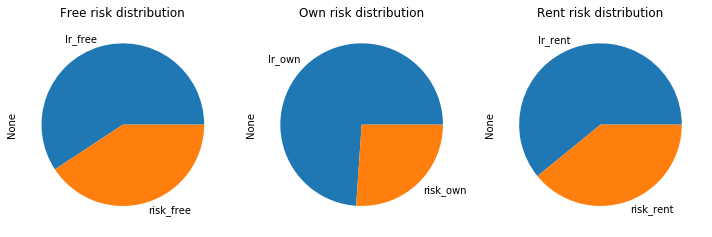

In [21]:
plt.figure(figsize=(10,30))
plt.subplot(131)
pd.Series({'lr_free': lr_free, 'risk_free': hr_free}).plot(kind='pie').set_title('Free risk distribution')
plt.subplot(132)
pd.Series({'lr_own': lr_own, 'risk_own': hr_own}).plot(kind='pie').set_title('Own risk distribution')
plt.subplot(133)
pd.Series({'lr_rent': lr_rent, 'risk_rent': hr_rent}).plot(kind='pie').set_title('Rent risk distribution')
plt.tight_layout()

Own Housing credits are less risky

In [22]:
df['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [23]:
df.groupby('Purpose').mean()['Risk']

Purpose
business               0.350515
car                    0.314540
domestic appliances    0.333333
education              0.389831
furniture/equipment    0.320442
radio/TV               0.221429
repairs                0.363636
vacation/others        0.416667
Name: Risk, dtype: float64

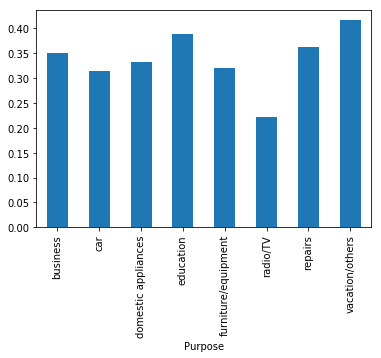

In [24]:
df.groupby('Purpose').mean()['Risk'].plot(kind='bar')

In [25]:
lr_business = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['business']
lr_car = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['car']
lr_domestic_appliances = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['domestic appliances']
lr_education = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['education']
lr_furniture_equipment = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['furniture/equipment']
lr_radio_tv = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['radio/TV']
lr_repairs = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['repairs']
lr_vacation_others = df[df['Risk'] == 0].groupby('Purpose').count()['Risk']['vacation/others']

hr_business = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['business']
hr_car = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['car']
hr_domestic_appliances = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['domestic appliances']
hr_education = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['education']
hr_furniture_equipment = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['furniture/equipment']
hr_radio_tv = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['radio/TV']
hr_repairs = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['repairs']
hr_vacation_others = df[df['Risk'] == 1].groupby('Purpose').count()['Risk']['vacation/others']

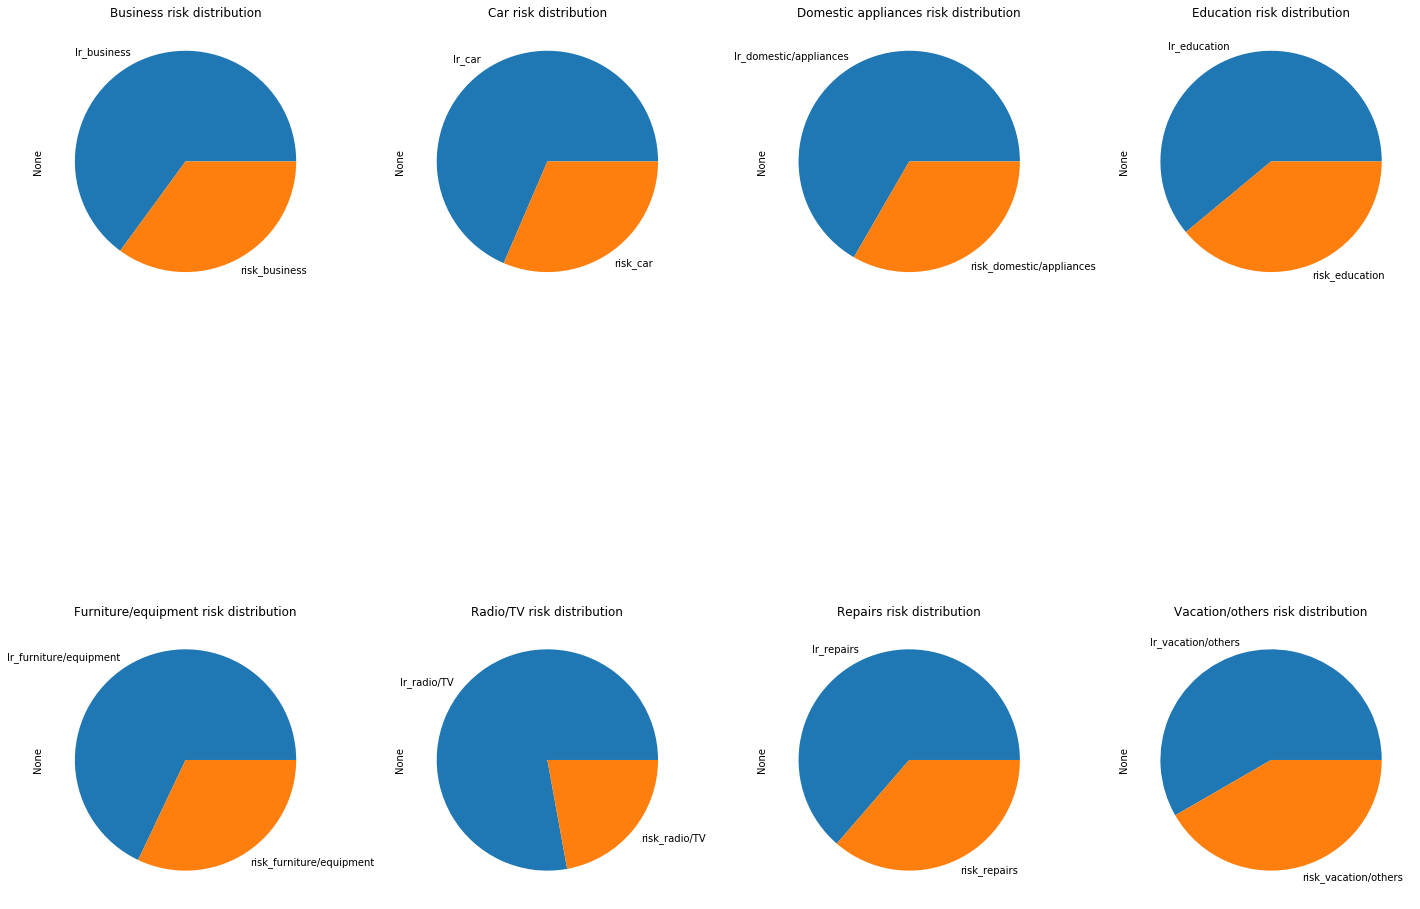

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(241)
pd.Series({'lr_business': lr_business, 'risk_business': hr_business}).plot(kind='pie').set_title('Business risk distribution')
plt.subplot(242)
pd.Series({'lr_car': lr_car, 'risk_car': hr_car}).plot(kind='pie').set_title('Car risk distribution')
plt.subplot(243)
pd.Series({'lr_domestic/appliances': lr_domestic_appliances, 'risk_domestic/appliances': hr_domestic_appliances}).plot(kind='pie').set_title('Domestic appliances risk distribution')
plt.subplot(244)
pd.Series({'lr_education': lr_education, 'risk_education': hr_education}).plot(kind='pie').set_title('Education risk distribution')
plt.subplot(245)
pd.Series({'lr_furniture/equipment': lr_furniture_equipment, 'risk_furniture/equipment': hr_furniture_equipment}).plot(kind='pie').set_title('Furniture/equipment risk distribution')
plt.subplot(246)
pd.Series({'lr_radio/TV': lr_radio_tv, 'risk_radio/TV': hr_radio_tv}).plot(kind='pie').set_title('Radio/TV risk distribution')
plt.subplot(247)
pd.Series({'lr_repairs': lr_repairs, 'risk_repairs': hr_repairs}).plot(kind='pie').set_title('Repairs risk distribution')
plt.subplot(248)
pd.Series({'lr_vacation/others': lr_vacation_others, 'risk_vacation/others': hr_vacation_others}).plot(kind='pie').set_title('Vacation/others risk distribution')
plt.tight_layout()

Radio purposes are less risky

In [27]:
df['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [28]:
df['Saving accounts'].fillna('null', inplace=True)

In [29]:
df.groupby('Saving accounts').mean()['Risk']

Saving accounts
little        0.359867
moderate      0.330097
null          0.174863
quite rich    0.174603
rich          0.125000
Name: Risk, dtype: float64

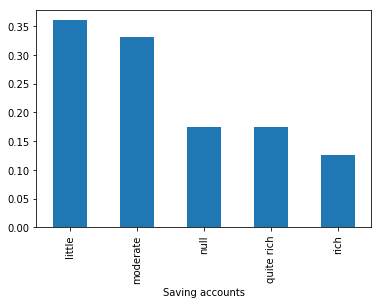

In [30]:
df.groupby('Saving accounts').mean()['Risk'].plot(kind='bar')

In [31]:
lr_little = df[df['Risk'] == 0].groupby('Saving accounts').count()['Risk']['little']
lr_moderate = df[df['Risk'] == 0].groupby('Saving accounts').count()['Risk']['moderate']
lr_null = df[df['Risk'] == 0].groupby('Saving accounts').count()['Risk']['null']
lr_quite_rich = df[df['Risk'] == 0].groupby('Saving accounts').count()['Risk']['quite rich']
lr_rich = df[df['Risk'] == 0].groupby('Saving accounts').count()['Risk']['rich']

hr_little = df[df['Risk'] == 1].groupby('Saving accounts').count()['Risk']['little']
hr_moderate = df[df['Risk'] == 1].groupby('Saving accounts').count()['Risk']['moderate']
hr_null = df[df['Risk'] == 1].groupby('Saving accounts').count()['Risk']['null']
hr_quite_rich = df[df['Risk'] == 1].groupby('Saving accounts').count()['Risk']['quite rich']
hr_rich = df[df['Risk'] == 1].groupby('Saving accounts').count()['Risk']['rich']

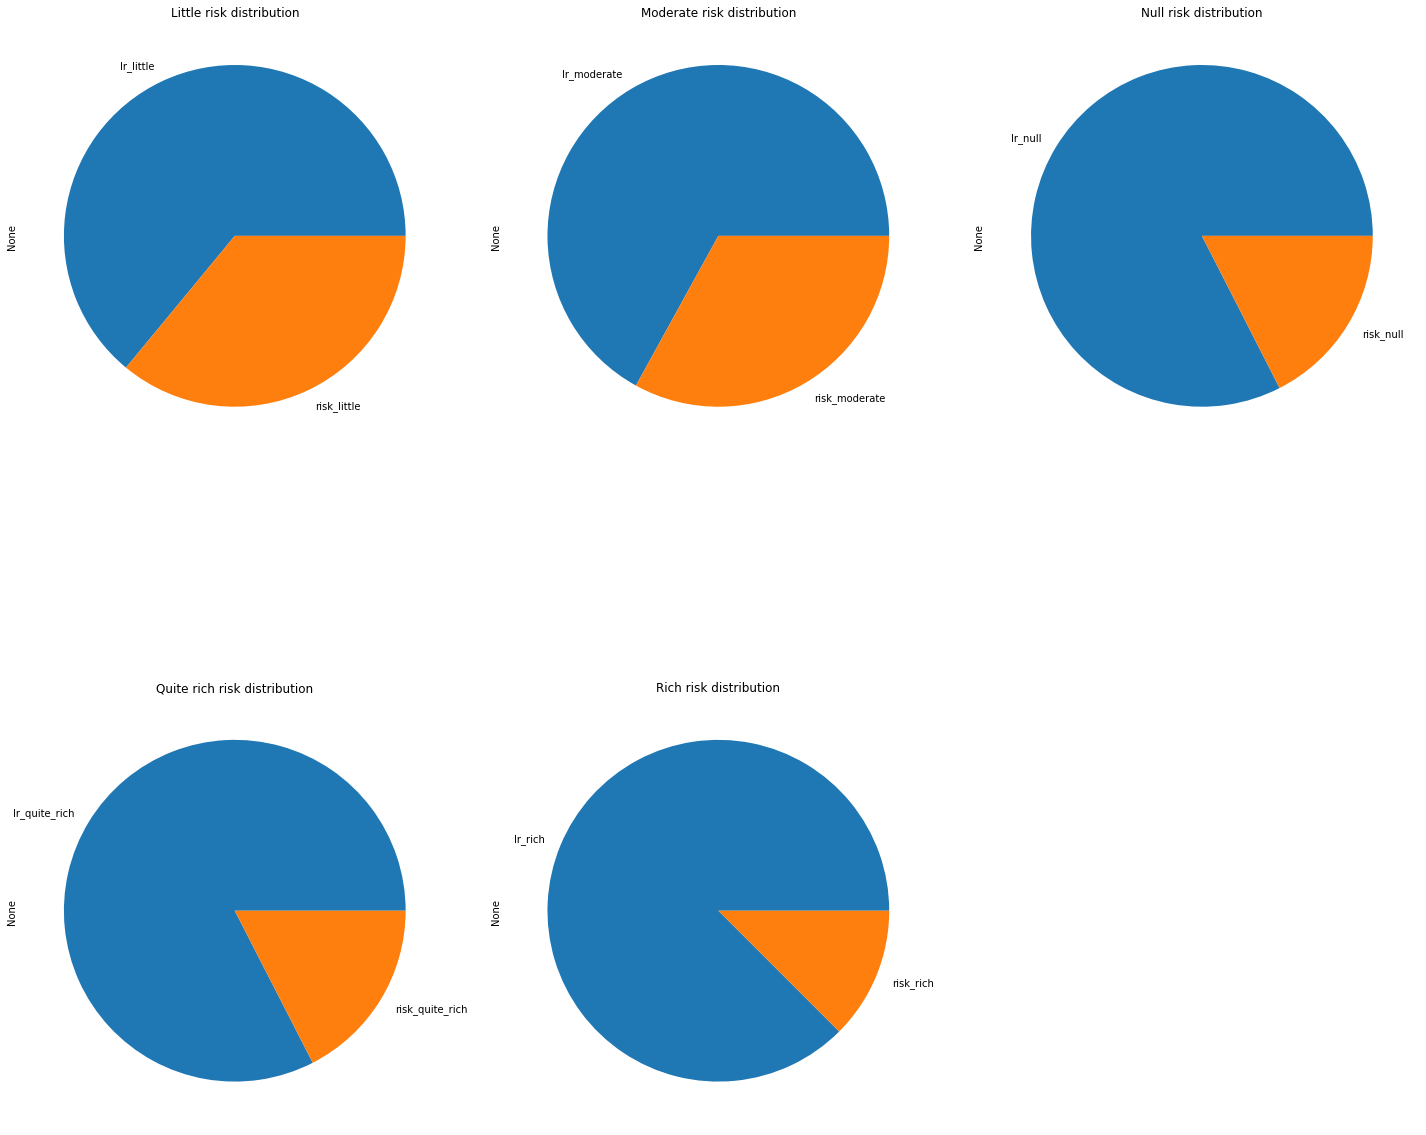

In [32]:
plt.figure(figsize=(20,20))
plt.subplot(231)
pd.Series({'lr_little': lr_little, 'risk_little': hr_little}).plot(kind='pie').set_title('Little risk distribution')
plt.subplot(232)
pd.Series({'lr_moderate': lr_moderate, 'risk_moderate': hr_moderate}).plot(kind='pie').set_title('Moderate risk distribution')
plt.subplot(233)
pd.Series({'lr_null': lr_null, 'risk_null': hr_null}).plot(kind='pie').set_title('Null risk distribution')
plt.subplot(234)
pd.Series({'lr_quite_rich': lr_quite_rich, 'risk_quite_rich': hr_quite_rich}).plot(kind='pie').set_title('Quite rich risk distribution')
plt.subplot(235)
pd.Series({'lr_rich': lr_rich, 'risk_rich': hr_rich}).plot(kind='pie').set_title('Rich risk distribution')

plt.tight_layout()

In [33]:
df['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [34]:
df['Checking account'].fillna('null', inplace=True)

In [35]:
df.groupby('Checking account').mean()['Risk']

Checking account
little      0.492701
moderate    0.390335
null        0.116751
rich        0.222222
Name: Risk, dtype: float64

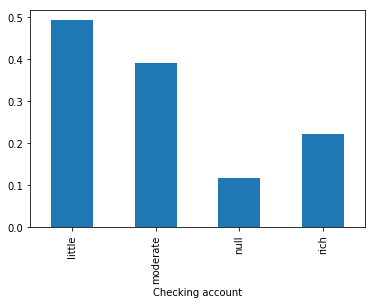

In [36]:
df.groupby('Checking account').mean()['Risk'].plot(kind='bar')

In [37]:
lr_little = df[df['Risk'] == 0].groupby('Checking account').count()['Risk']['little']
lr_moderate = df[df['Risk'] == 0].groupby('Checking account').count()['Risk']['moderate']
lr_null = df[df['Risk'] == 0].groupby('Checking account').count()['Risk']['null']
lr_rich = df[df['Risk'] == 0].groupby('Checking account').count()['Risk']['rich']

hr_little = df[df['Risk'] == 1].groupby('Checking account').count()['Risk']['little']
hr_moderate = df[df['Risk'] == 1].groupby('Checking account').count()['Risk']['moderate']
hr_null = df[df['Risk'] == 1].groupby('Checking account').count()['Risk']['null']
hr_rich = df[df['Risk'] == 1].groupby('Checking account').count()['Risk']['rich']

Text(0.5, 1.0, 'Rich risk distribution')

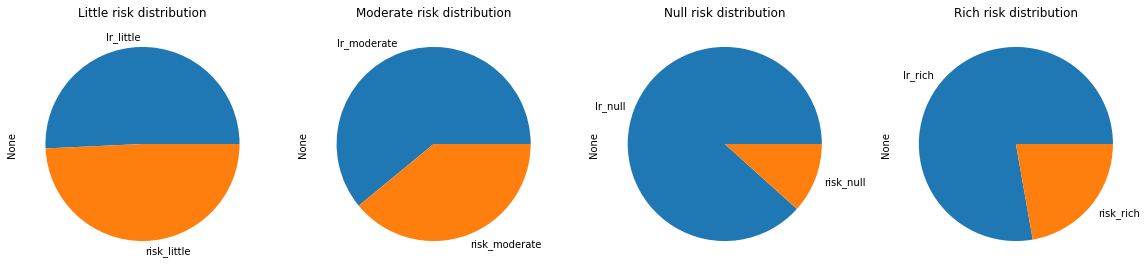

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(141)
pd.Series({'lr_little': lr_little, 'risk_little': hr_little}).plot(kind='pie').set_title('Little risk distribution')
plt.subplot(142)
pd.Series({'lr_moderate': lr_moderate, 'risk_moderate': hr_moderate}).plot(kind='pie').set_title('Moderate risk distribution')
plt.subplot(143)
pd.Series({'lr_null': lr_null, 'risk_null': hr_null}).plot(kind='pie').set_title('Null risk distribution')
plt.subplot(144)
pd.Series({'lr_rich': lr_rich, 'risk_rich': hr_rich}).plot(kind='pie').set_title('Rich risk distribution')

Some Statistics about numeric features

In [39]:
df.describe()[['Age', 'Duration', 'Credit amount']]

,Age,Duration,Credit amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


The max value of Duration seems an outlier

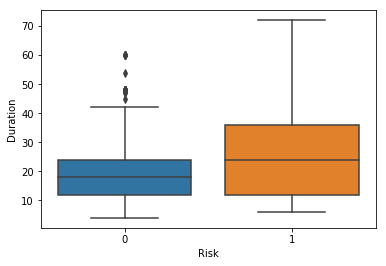

In [40]:
sns.boxplot(x="Risk", y="Duration", data=df)

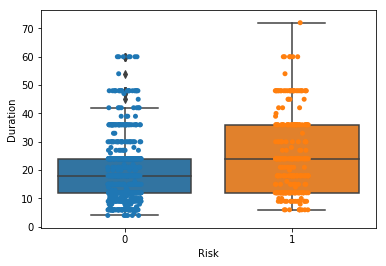

In [41]:
ax = sns.boxplot(x="Risk", y="Duration", data=df)
ax = sns.stripplot(x='Risk', y="Duration", data=df, jitter=True, edgecolor="gray")

In [42]:
df.loc[df['Duration'] > 60, 'Duration'] = 60

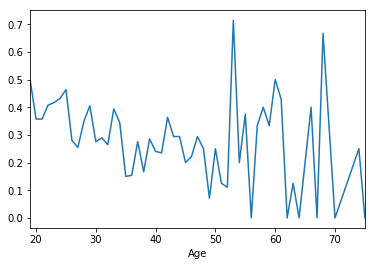

In [43]:
df.groupby('Age').mean()['Risk'].plot()

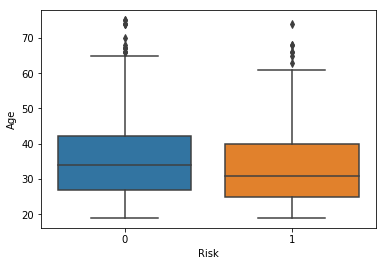

In [44]:
sns.boxplot(x="Risk", y="Age", data=df)

In [45]:
df['Age_young'] = np.zeros(1000, dtype=int)
df['Age_adult'] = np.zeros(1000, dtype=int)
df['Age_old'] = np.zeros(1000, dtype=int)

In [46]:
df.loc[df['Age'] < 27, 'Age_young'] = 1
df.loc[(df['Age'] >= 27) & (df['Age'] < 50), 'Age_adult'] = 1
df.loc[df['Age'] >= 50, 'Age_old'] = 1

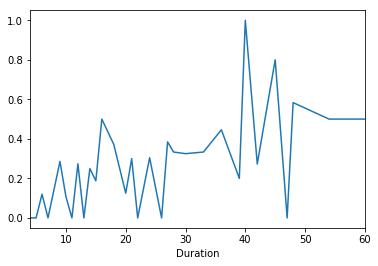

In [47]:
df.groupby('Duration').mean()['Risk'].plot()

In [48]:
df['Duration_short'] = np.zeros(1000, dtype=int)
df['Duration_med'] = np.zeros(1000, dtype=int)
df['Duration_long'] = np.zeros(1000, dtype=int)

In [49]:
df.loc[df['Duration'] < 12, 'Duration_short'] = 1
df.loc[(df['Duration'] >= 12) & (df['Duration'] < 30), 'Duration_med'] = 1
df.loc[df['Duration'] >= 30, 'Duration_long'] = 1

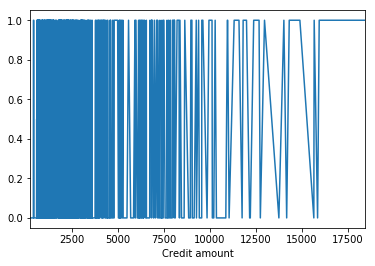

In [50]:
df.groupby('Credit amount').mean()['Risk'].plot()

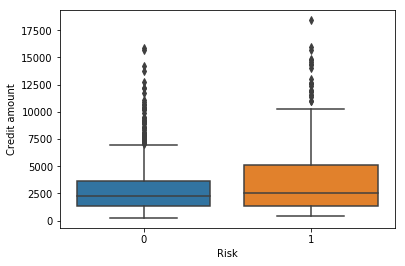

In [51]:
sns.boxplot(x="Risk", y="Credit amount", data=df)

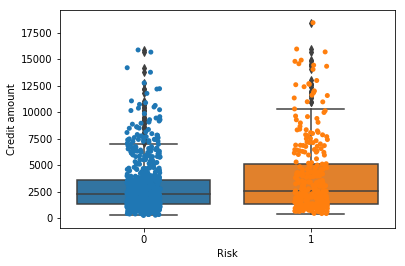

In [53]:
ax = sns.boxplot(x="Risk", y="Credit amount", data=df)
ax = sns.stripplot(x='Risk', y="Credit amount", data=df, jitter=True, edgecolor="gray")

In [63]:
df['Credit_small'] = np.zeros(1000, dtype=int)
df['Credit_med'] = np.zeros(1000, dtype=int)
df['Credit_big'] = np.zeros(1000, dtype=int)

In [65]:
df.loc[df['Credit amount'] < 1365.5, 'Credit_small'] = 1
df.loc[(df['Credit amount'] >= 1365.5) & (df['Credit amount'] < 10000), 'Credit_med'] = 1
df.loc[df['Credit amount'] >= 10000, 'Credit_big'] = 1

## Data Cleaning

In [54]:
# Null values, encoding categorical values....

In [55]:
df.dtypes[df.dtypes == np.object]

Sex                 object
Housing             object
Saving accounts     object
Checking account    object
Purpose             object
dtype: object

In [56]:
df.isnull().any()

ID                  False
Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
Age_young           False
Age_adult           False
Age_old             False
Duration_short      False
Duration_med        False
Duration_long       False
Credit_small         True
Credit_med           True
Credit_big           True
dtype: bool

In [57]:
df.isnull().sum()[df.isnull().any()]

Credit_small    750
Credit_med      290
Credit_big      960
dtype: int64

In [58]:
(df.dtypes == np.object) & (df.isnull().any())

ID                  False
Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
Age_young           False
Age_adult           False
Age_old             False
Duration_short      False
Duration_med        False
Duration_long       False
Credit_small        False
Credit_med          False
Credit_big          False
dtype: bool

In [59]:
df.loc[df['Sex'] == 'male', 'Sex'] = 0
df.loc[df['Sex'] == 'female', 'Sex'] = 1
df['Sex'] = df['Sex'].astype(int)

In [60]:
df = pd.get_dummies(df['Job'], prefix='Job').merge(df, left_index=True, right_index=True)
df = pd.get_dummies(df['Housing'], prefix='Housing').merge(df, left_index=True, right_index=True)
df = pd.get_dummies(df['Purpose'], prefix='Purpose').merge(df, left_index=True, right_index=True)
df = pd.get_dummies(df['Saving accounts'], prefix='Savings').merge(df, left_index=True, right_index=True)
df = pd.get_dummies(df['Checking account'], prefix='Checking').merge(df, left_index=True, right_index=True)
df.head()

,Checking_little,Checking_moderate,Checking_null,Checking_rich,Savings_little,Savings_moderate,Savings_null,Savings_quite rich,Savings_rich,Purpose_business,...,Risk,Age_young,Age_adult,Age_old,Duration_short,Duration_med,Duration_long,Credit_small,Credit_med,Credit_big
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,1.0,NaN,NaN
1,0,1,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,1,NaN,1.0,NaN
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,NaN,1.0,NaN
3,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,NaN,1.0,NaN
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,NaN,1.0,NaN


In [61]:
df.describe()

,Checking_little,Checking_moderate,Checking_null,Checking_rich,Savings_little,Savings_moderate,Savings_null,Savings_quite rich,Savings_rich,Purpose_business,...,Risk,Age_young,Age_adult,Age_old,Duration_short,Duration_med,Duration_long,Credit_small,Credit_med,Credit_big
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,250.0,710.0,40.0
mean,0.274000,0.269000,0.394000,0.063000,0.603000,0.103000,0.18300,0.063000,0.048000,0.097000,...,0.300000,0.240000,0.635000,0.125000,0.18000,0.607000,0.213000,1.0,1.0,1.0
std,0.446232,0.443662,0.488879,0.243085,0.489521,0.304111,0.38686,0.243085,0.213873,0.296106,...,0.458487,0.427297,0.481671,0.330884,0.38438,0.488661,0.409633,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,1.0,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,1.0,1.0
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.0,1.0,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.0,1.0,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.0,1.0


## Feature Selection based on Correlation

In [66]:
df.corr().abs().filter(['Risk']).style.background_gradient()

,Risk
Checking_little,0.258333
Checking_moderate,0.119581
Checking_null,0.322436
Checking_rich,0.0440095
Savings_little,0.161007
Savings_moderate,0.0222555
Savings_null,0.129238
Savings_quite rich,0.0709541
Savings_rich,0.0857493
Purpose_business,0.0361291


In [160]:
features = ['Checking_little', 'Checking_null', 'Checking_moderate', 'Savings_little', 'Savings_null', 'Purpose_radio/TV', 'Housing_own',
            'Credit_big', 'Duration_short', 'Age_young']
#features = df.columns.tolist()
#features.remove('Risk')
#features.remove('Job')
#features.remove('Housing')
#features.remove('Saving accounts')
#features.remove('Checking account')
#features.remove('Purpose')

In [161]:
X = df[features].values
y = df['Risk'].values

In [131]:
len(features)

10

## Evaluation

Uncomment the Algorithm you want to use

In [171]:
# Create the model and the hyperparameters range to optimize
less_than_1 = [.0001,.001,.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
more_than_1 = list(np.arange(1,11))
classifier = MultinomialNB(alpha=0.0001)
params = {'clf__alpha': less_than_1 + more_than_1}
#classifier = GaussianProcessClassifier()
#classifier = DecisionTreeClassifier()

#params = {'clf__max_depth': np.append(np.arange(1, 21), None), 'clf__criterion': ['gini', 'entropy'], 
#          'clf__splitter': ['best', 'random'], 'clf__class_weight': ['balanced', None], 
#          'clf__max_features': ['auto', 'log2', None]}
#classifier = LogisticRegression(n_jobs=-1)
#classifier = LinearSVC(dual=False)
#params = {'clf__penalty': ['l1','l2'], 'clf__tol': less_than_1, 'clf__C': np.append(less_than_1, np.arange(1,16))}
#classifier = KNeighborsClassifier()
#params = {'n_neighbors': np.arange(1,22), 'weights': ['uniform', 'distance'], 
#          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
#classifier = RandomForestClassifier(n_jobs=-1)
#params = {'clf__n_estimators': np.arange(50, 1001, 50), 'clf__max_depth': np.append(np.arange(1, 11), None)}
#classifier = MLPClassifier(hidden_layer_sizes=(50,50))
#params = {'clf__activation': ['logistic', 'tanh', 'relu'], 'clf__alpha': less_than_1}
#classifier = BaggingClassifier(base_estimator=LogisticRegression(n_jobs=-1), n_jobs=-1)
#params = {'clf__n_estimators': np.arange(50, 1001, 50), 'clf__max_samples': [0.5, 0.8, 1.0],
#          'clf__max_features': [0.5, 0.8, 1.0]}
#params = {'clf__bootstrap': [True, False], 'clf__bootstrap_features': [True, False]}
#classifier = AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1))
#params = {'clf__n_estimators': np.arange(50, 1001, 50), 'clf__learning_rate': less_than_1}
#classifier = GradientBoostingClassifier(max_depth=9)
model = Pipeline([
    #('scaler', MaxAbsScaler()),
    #('selection', SelectKBest(f_classif, k=5)), # Feature selection
    ('clf', classifier)
])

In [168]:
# Cross Validate
def evaluate(estimator, data, label):    
    scores = cross_validate(estimator, data, label, cv=3, 
                            scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], 
                            n_jobs=-1)
    accuracy_score = scores['test_accuracy']
    precision_score = scores['test_precision_weighted']
    recall_score = scores['test_recall_weighted']
    f1_score = scores['test_f1_weighted']

    print("Accuracy score: {0:.3f} (+/- {1:.3f})".format(accuracy_score.mean(), accuracy_score.std()))
    print("Precision score: {0:.3f} (+/- {1:.3f})".format(precision_score.mean(), precision_score.std()))
    print("Recall score: {0:.3f} (+/- {1:.3f})".format(recall_score.mean(), recall_score.std()))
    print("F1 score: {0:.3f} (+/- {1:.3f})".format(f1_score.mean(), f1_score.std()))

In [169]:
evaluate(model, X, y)

Accuracy score: 0.707 (+/- 0.007)
Precision score: 0.698 (+/- 0.026)
Recall score: 0.707 (+/- 0.007)
F1 score: 0.663 (+/- 0.033)


## Optimization

In [165]:
def optimize_and_evaluate(estimator, params, data, label):
    gs = GridSearchCV(estimator, params, cv=3, scoring='f1_weighted', iid=False, n_jobs=-1)
    gs.fit(data, label)

    # summarize the results of the grid search
    print("Best score: ", gs.best_score_)
    print("Best params: ", gs.best_params_)

    # Set best params to the estimators        
    model.set_params(**gs.best_params_)

    # Cross validate
    evaluate(estimator, data, label)

In [166]:
optimize_and_evaluate(model, params, X, y)

Best score:  0.7255864625111769
Best params:  {'clf__alpha': 0.0001}
Accuracy score: 0.740 (+/- 0.021)
Precision score: 0.724 (+/- 0.026)
Recall score: 0.740 (+/- 0.021)
F1 score: 0.726 (+/- 0.026)


## Same Analysis balancing the dataset

In [99]:
rus = RandomUnderSampler(random_state=42)
#nm = NearMiss(version=3)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 300), (1, 300)]


In [115]:
evaluate(model, X_resampled, y_resampled)

Accuracy score: 0.703 (+/- 0.021)
Precision score: 0.704 (+/- 0.021)
Recall score: 0.703 (+/- 0.021)
F1 score: 0.703 (+/- 0.021)


In [116]:
optimize_and_evaluate(model, params, X_resampled, y_resampled)

/home/mandofu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best score:  0.7249528596660243
Best params:  {'clf__activation': 'relu', 'clf__alpha': 1.0}
Accuracy score: 0.713 (+/- 0.021)
Precision score: 0.714 (+/- 0.021)
Recall score: 0.713 (+/- 0.021)
F1 score: 0.713 (+/- 0.020)
